In [1]:
import numpy as np
import hist
import matplotlib.pyplot as plt
from scipy.integrate import quad
import os

# Fit functions definitions

In [2]:
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

def VWG(x, N, mu, alpha, beta):
    X = (x-mu)/mu
    sig = alpha + beta*X
    return N*np.exp(-(x-mu)**2/(2*sig**2))

def PL(x, N, mu, a1, a2, a3):
    return N*(1+a1*x)/(a2*x+a3*x)
    #return N*(a1*x**2+a2*x+a3)  # test
    
def DE(x, N, a1, a2, a3):
    return N*(np.exp(a1*x) + a2*np.exp(a3*x))

def expVWG(x, N, mu, alpha, beta):
    X = (x-mu)/mu
    sig = alpha + beta*X
    return np.exp(N*np.exp(-(x-mu)**2/(2*sig**2)))

def crystalball(x, N, mu, sig, alphaL, nL, alphaR, nR):
    AL = ( nL / np.absolute( alphaL ) )**nL * np.exp( -1 * np.absolute( alphaL )**2 / 2 )
    AR = ( nR / np.absolute( alphaR ) )**nR * np.exp( -1 * np.absolute( alphaR )**2 / 2 )
    BL = nL / np.absolute( alphaL ) - np.absolute( alphaL )
    BR = nR / np.absolute( alphaR ) - np.absolute( alphaR )

    result = np.zeros(np.shape(x))
    
    rel = ( x - mu )/sig
    I1 = rel < -1 * alphaL
    I2 = (rel >= -1 * alphaL) * (rel <= alphaR)
    I3 = rel > alphaR
    result[I1] = AL * (BL - rel[I1])**(-nL)
    result[I2] = np.exp(-1 * rel[I2]**2 / 2)
    result[I3] = AR*(BR + rel[I3])**(-nR)
        
    return result * N #/ (np.sqrt(2 * np.pi) * sig)

def datamodel(x,
            N1, mu1, sig1, alphaL1, nL1, alphaR1, nR1,
            N2, mu2, sig2, alphaL2, nL2, alphaR2, nR2,
            Nbg, a1, a2, a3):
    return crystalball(x, N1, mu1, sig1, alphaL1, nL1, alphaR1, nR1) \
        + crystalball(x, N2, mu2, sig2, alphaL2, nL2, alphaR2, nR2) \
        + expVWG(x, Nbg, a1, a2, a3)

#def mcmodel(x,
#            N1, mu1, sig1, alphaL1, nL1, alphaR1, nR1,
#            N2, mu2, sig2, alphaL2, nL2, alphaR2, nR2):
#    return crystalball(x, N1, mu1, sig1, alphaL1, nL1, alphaR1, nR1) \
#        + crystalball(x, N2, mu2, sig2, alphaL2, nL2, alphaR2, nR2)


# Fit loop (over $p_T$ cuts)

/tmp/ipykernel_1241/1478693489.py:24: RuntimeWarning: invalid value encountered in scalar power
  AR = ( nR / np.absolute( alphaR ) )**nR * np.exp( -1 * np.absolute( alphaR )**2 / 2 )
/tmp/ipykernel_1241/1478693489.py:36: RuntimeWarning: invalid value encountered in power
  result[I3] = AR*(BR + rel[I3])**(-nR)
/tmp/ipykernel_1241/1478693489.py:24: RuntimeWarning: invalid value encountered in scalar power
  AR = ( nR / np.absolute( alphaR ) )**nR * np.exp( -1 * np.absolute( alphaR )**2 / 2 )
/tmp/ipykernel_1241/1478693489.py:36: RuntimeWarning: invalid value encountered in power
  result[I3] = AR*(BR + rel[I3])**(-nR)
/tmp/ipykernel_1241/1478693489.py:24: RuntimeWarning: invalid value encountered in scalar power
  AR = ( nR / np.absolute( alphaR ) )**nR * np.exp( -1 * np.absolute( alphaR )**2 / 2 )
/tmp/ipykernel_1241/1478693489.py:36: RuntimeWarning: invalid value encountered in power
  result[I3] = AR*(BR + rel[I3])**(-nR)
/tmp/ipykernel_1241/1478693489.py:24: RuntimeWarning: invalid

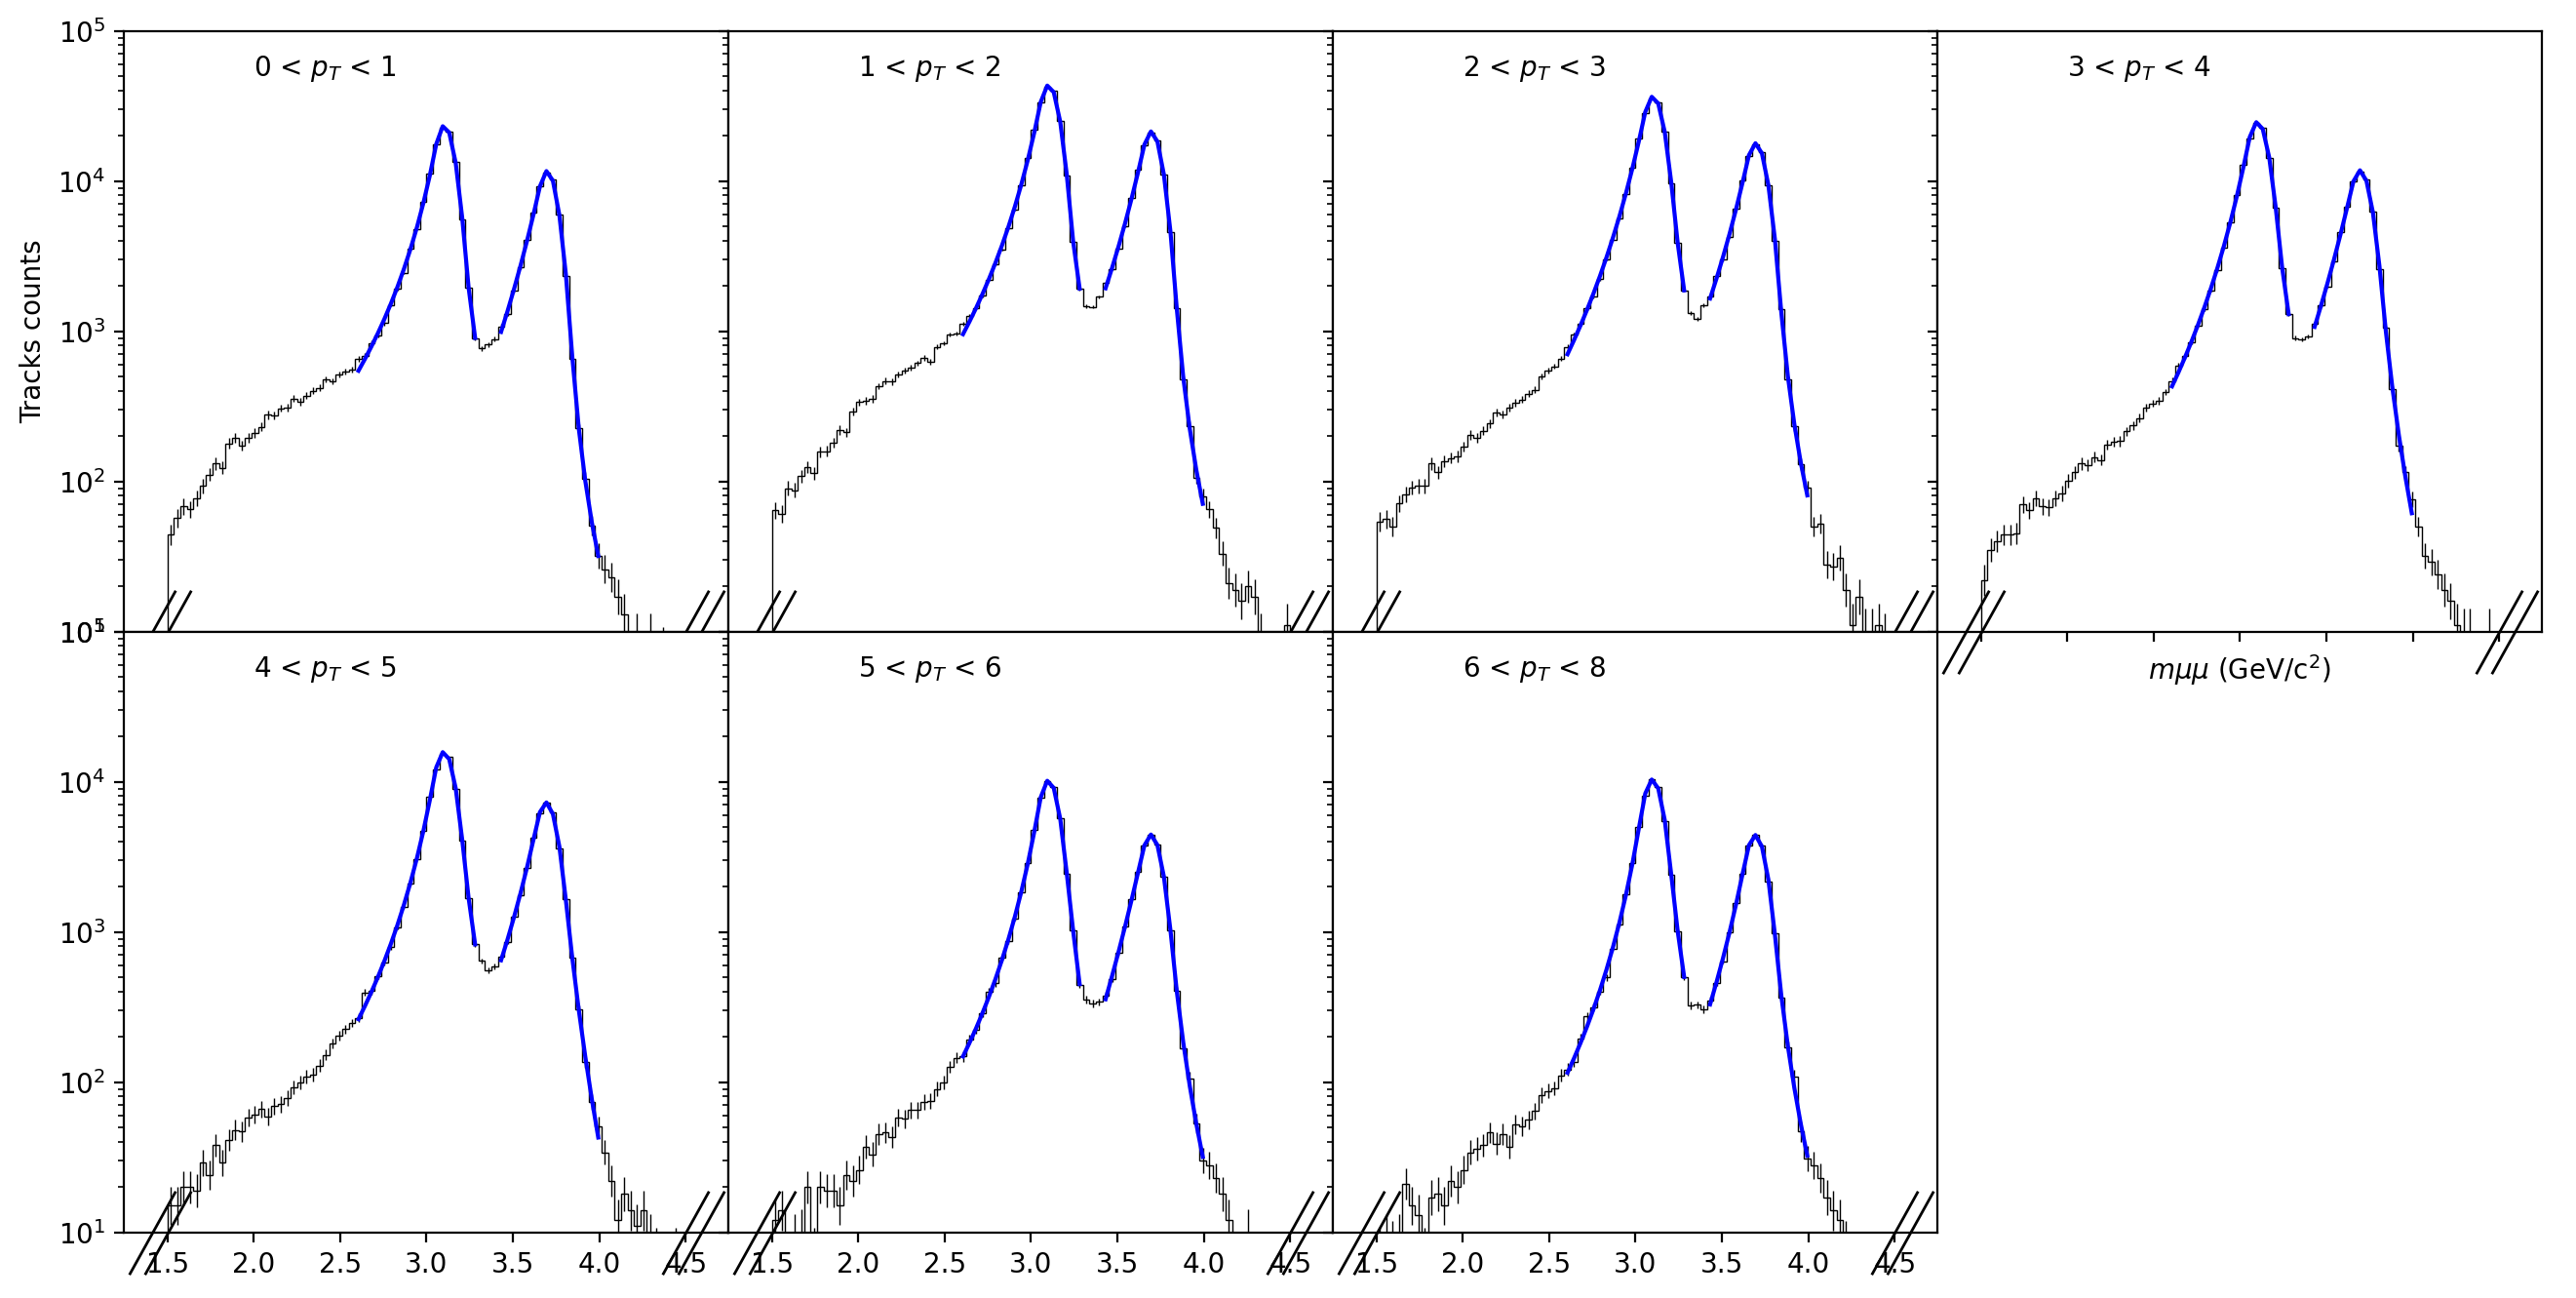

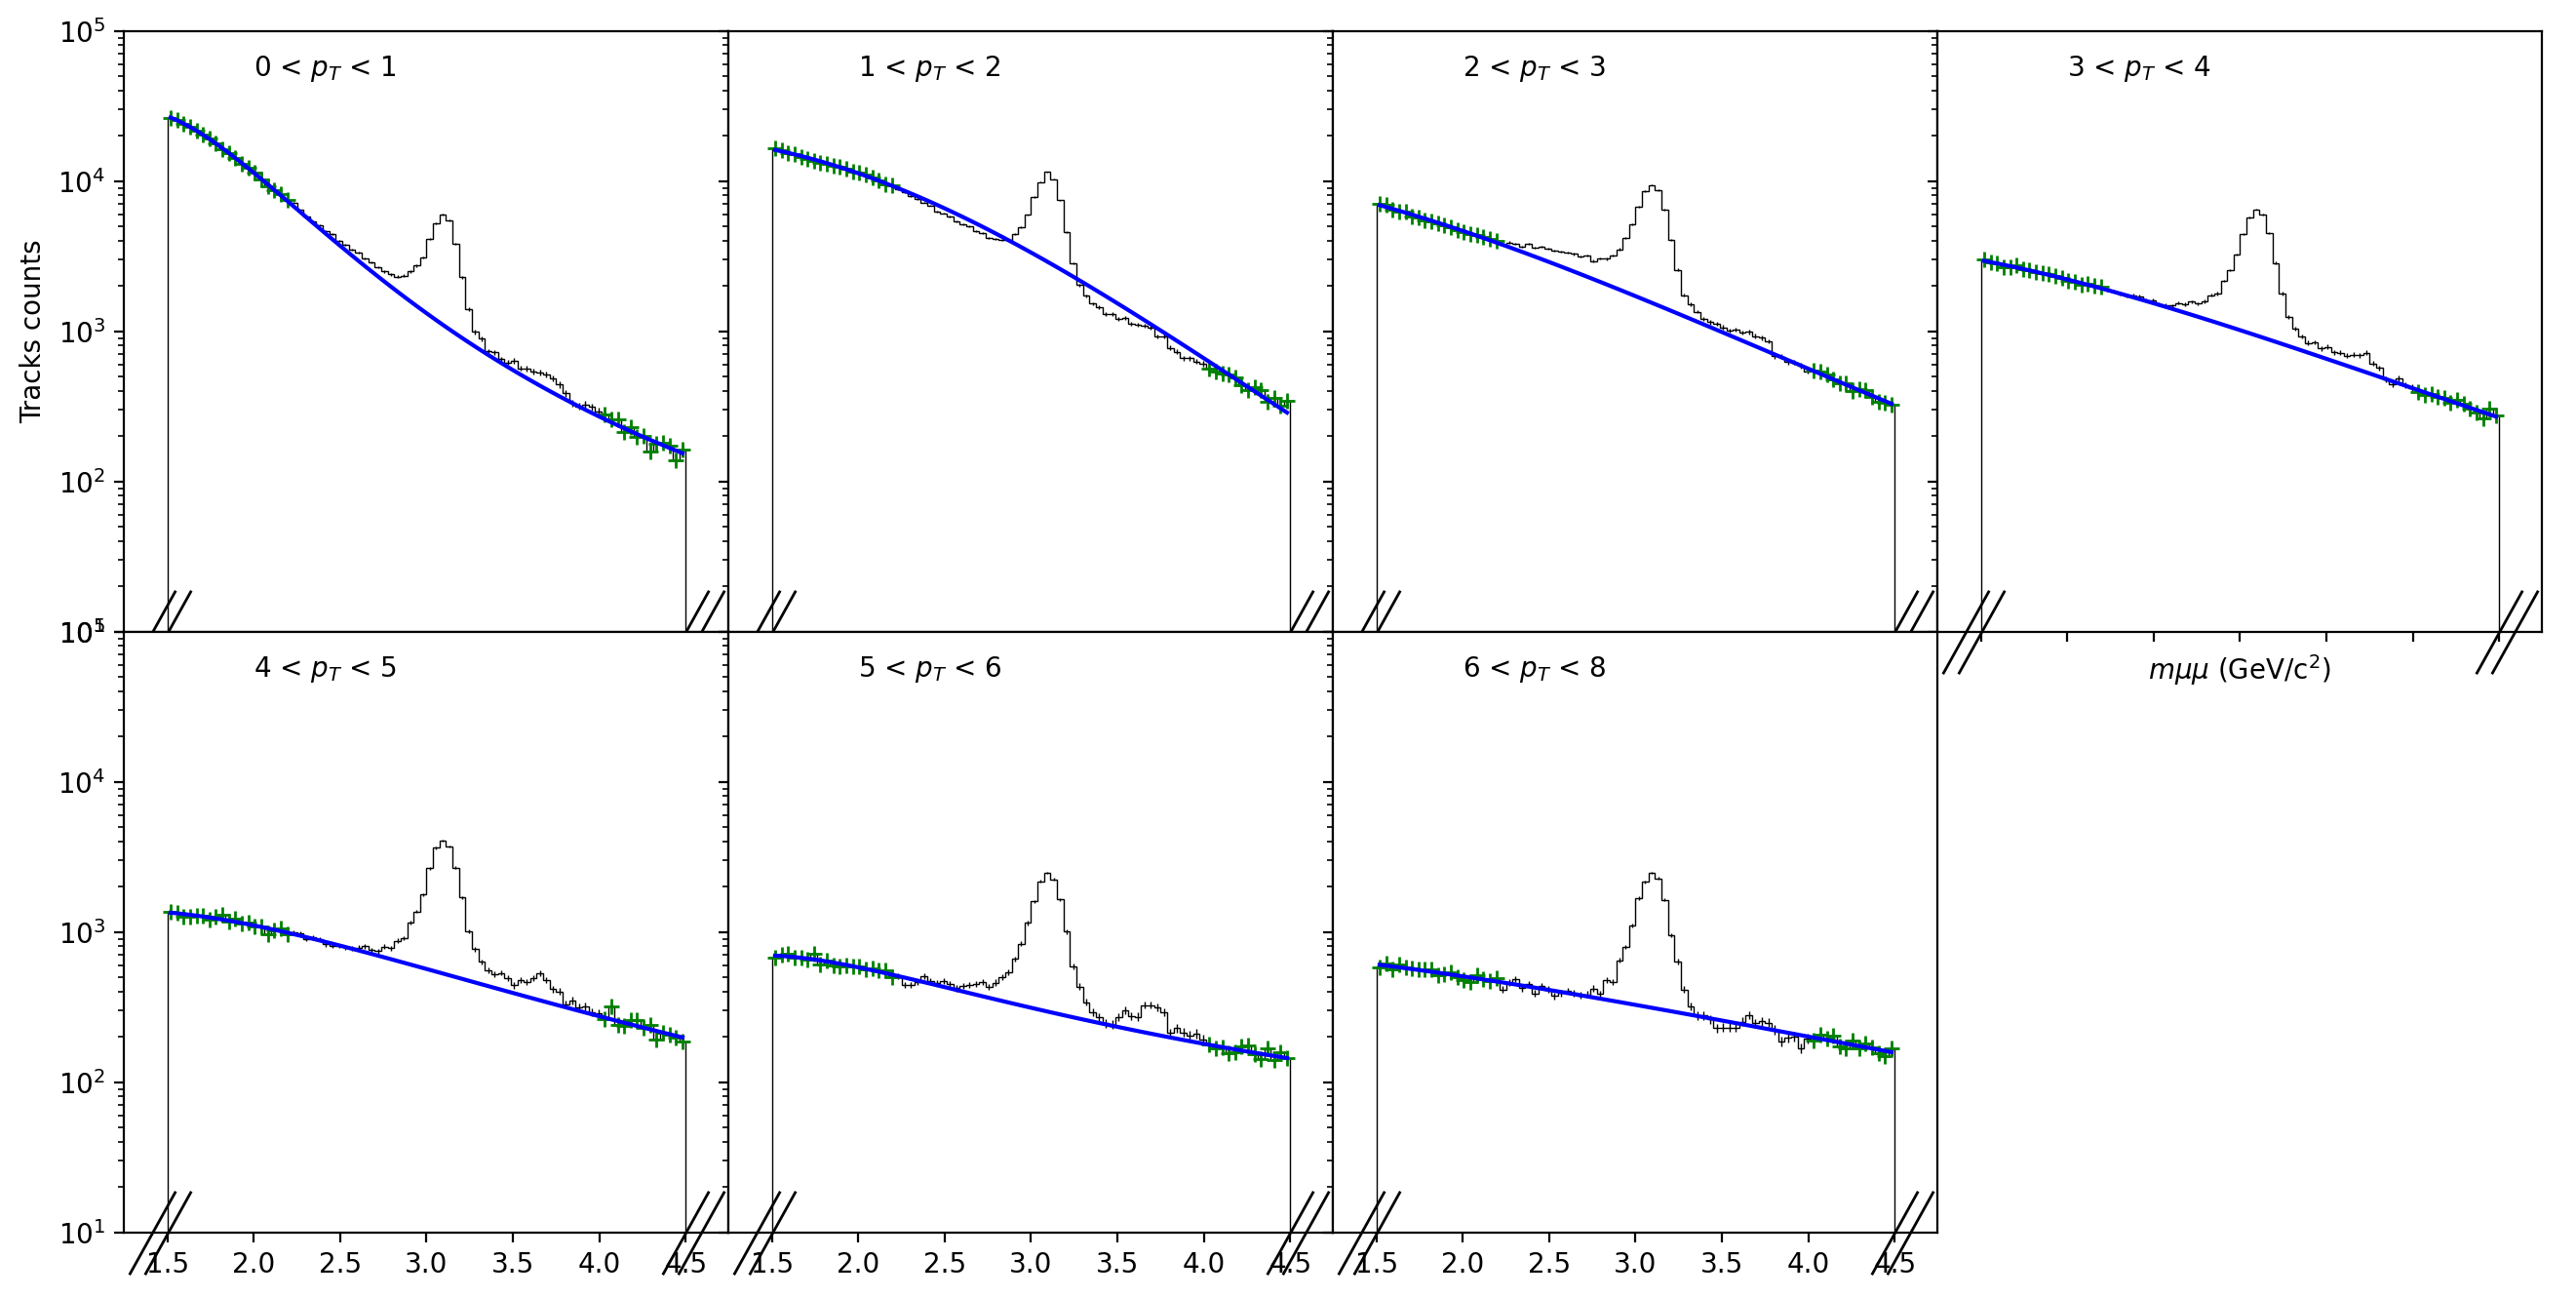

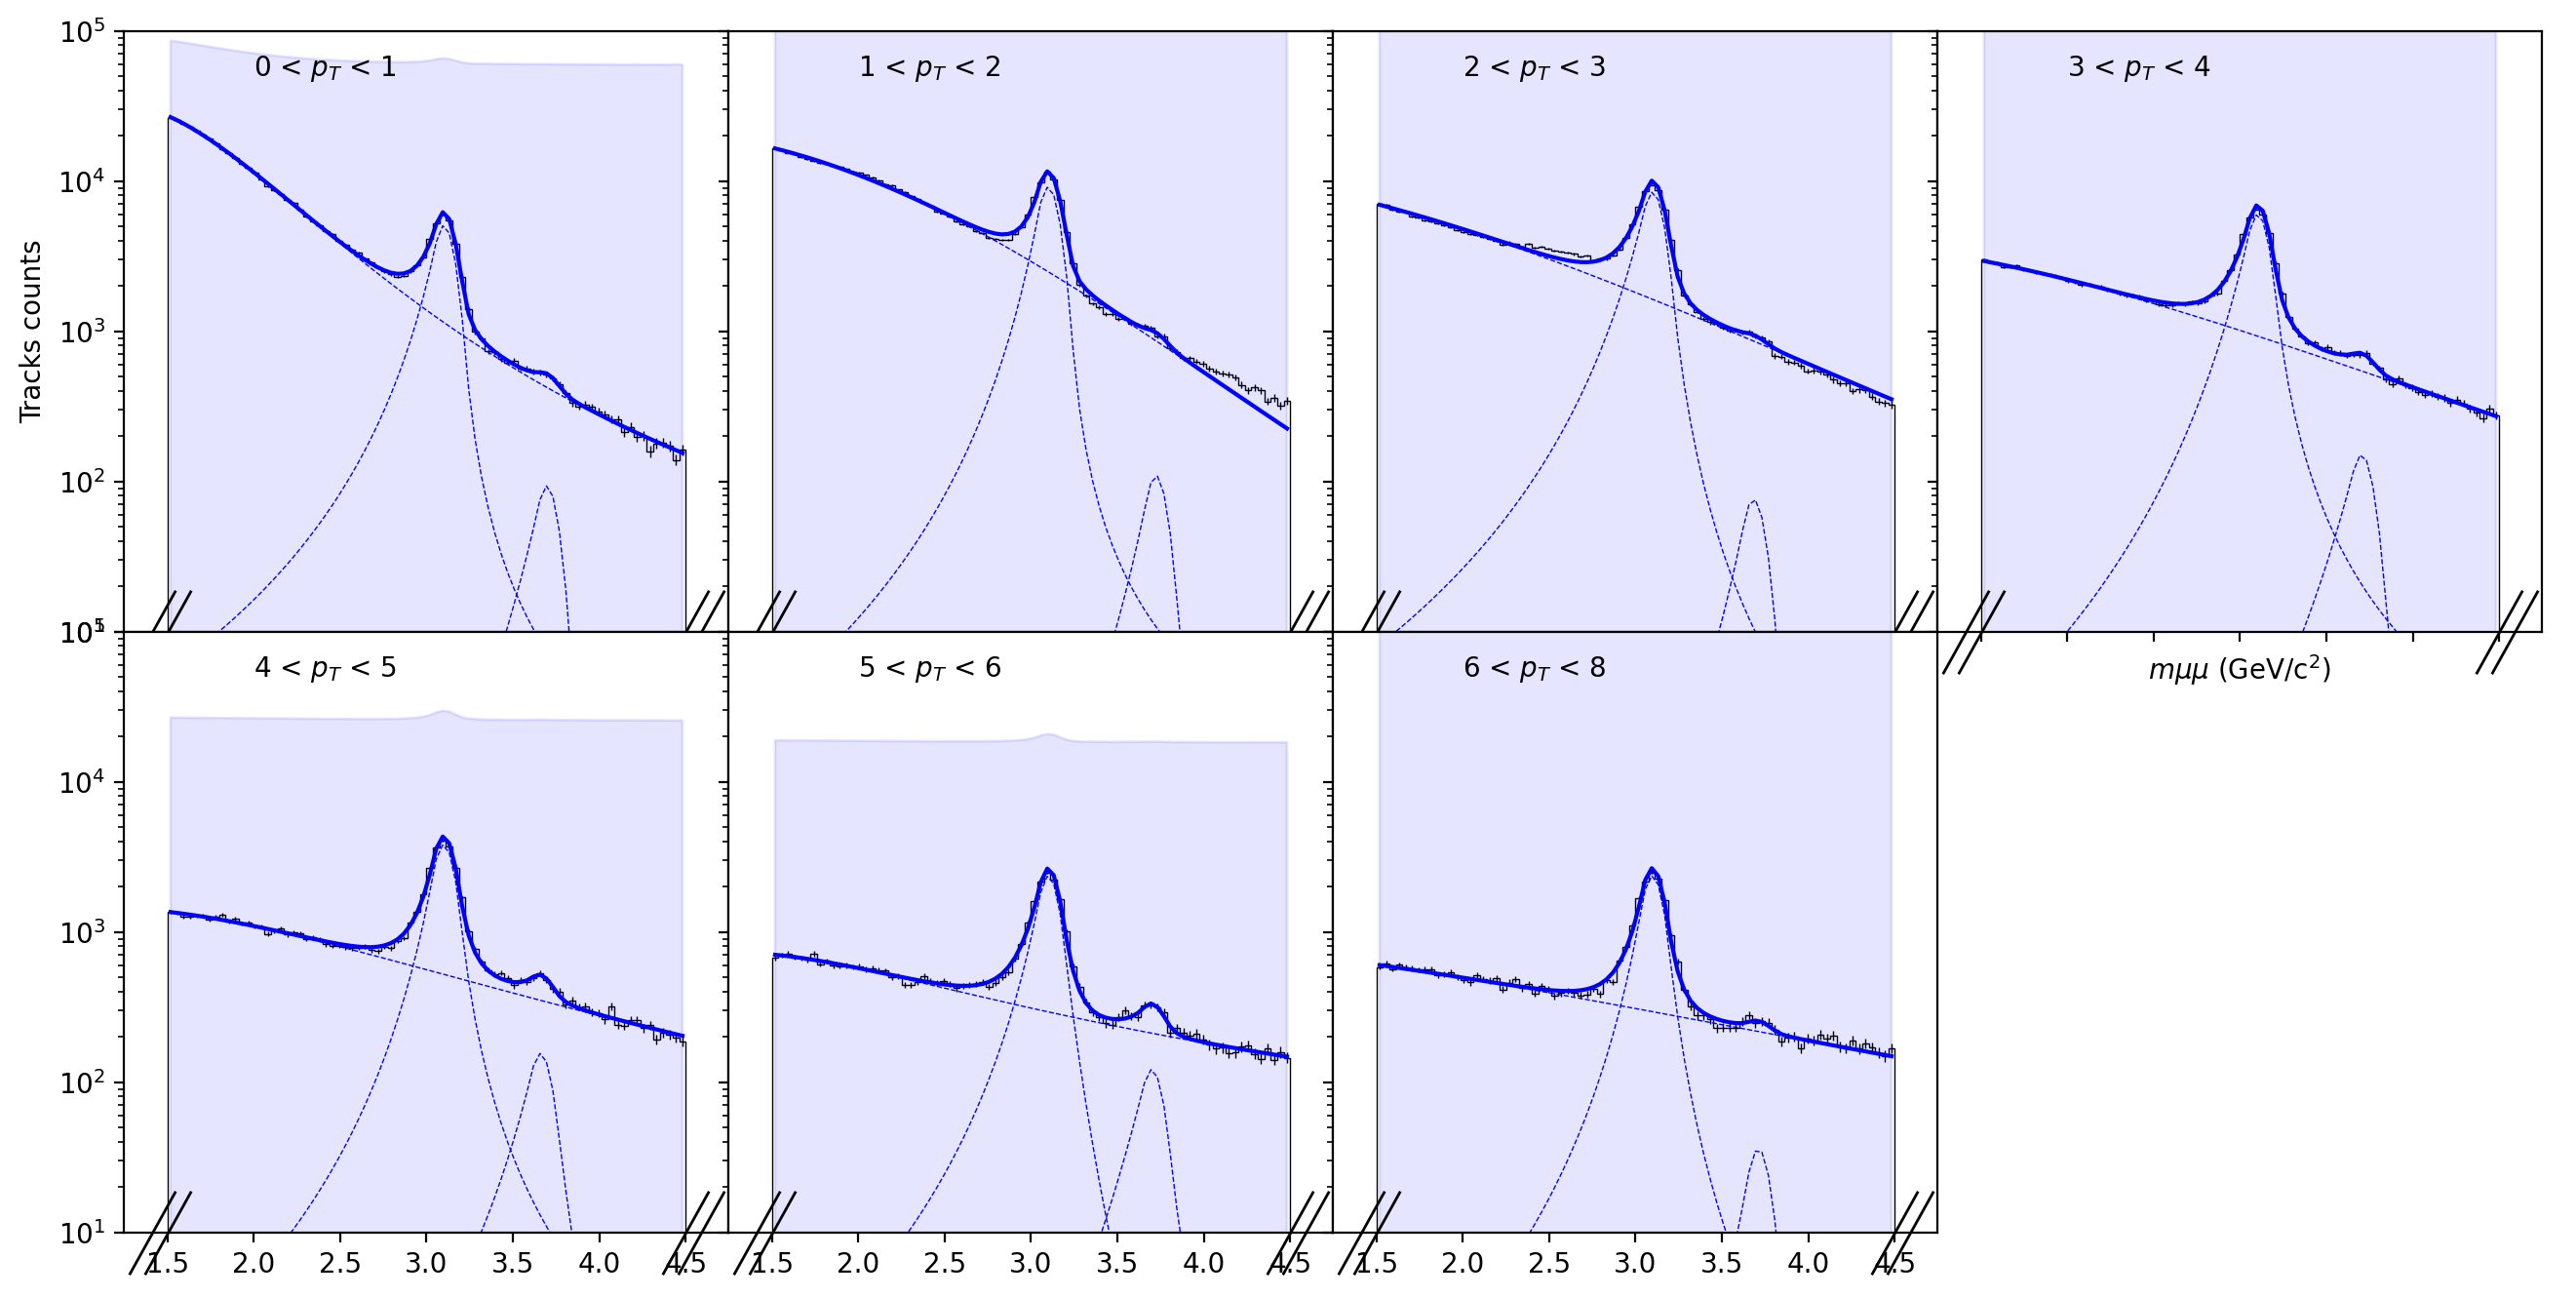

In [7]:
fit_on = True
nruns = 108  #  all: 108

def gethistdata(h,xmin,xmax):
    ''' Get data from histo '''
    y,x = h[xmin*1j:xmax*1j].to_numpy()
    x = x[:-1]+(x[1]-x[0])/2  # set x to middles instead of lower bound of bins
    return x,y

def fillhist(h,type,pTl,pTu):
    f = open(f'mass/{type}.CMUL_pT{pTl}-{pTu}.npy', 'rb')
    for i in range(nruns):
        A = np.load(f)
        #print(A)
        h.fill(A)
    f.close()
    
def setaxes(ax):
    ax.set_ylim(1e1,1e5)
    ax.set_yscale("log")
    ax.text(2, 5e4, f"{pTl} < $p_T$ < {pTu}")
    ax.set_xlabel('')
    if i==3: ax.set_xlabel('$m\mu\mu$ (GeV/c$^2$)')
    if i==0: ax.set_ylabel("Tracks counts")


def mklb(p0, var):
    return p0*(1-np.sign(p0)*var)

def mkub(p0, var):
    return p0*(1+np.sign(p0)*var)

nbin = 80
massmin = 1.5
massmax = 4.5


fig = []
axs = []
for i in range(3):
    fig.append(plt.figure(i+1, dpi=200, figsize=(16,8)))
    gs = fig[i].add_gridspec(2, 4, hspace=0, wspace=0)
    axs.append(gs.subplots(sharex='col', sharey='row'))
    axs[i][1,-1].remove()
    


pTcuts = [0,1,2,3,4,5,6,8]
for i in range(len(pTcuts)-1):
    pTl = pTcuts[i]
    pTu = pTcuts[i+1]

    # Fill histograms
    hmc =   hist.Hist(hist.axis.Regular(bins=nbin,start=massmin,stop=massmax))
    hdata = hist.Hist(hist.axis.Regular(bins=nbin,start=massmin,stop=massmax))
    fillhist(hmc,'mc',pTl,pTu)
    fillhist(hdata,'data',pTl,pTu)
    
    mass,Nmc = gethistdata(hmc,massmin,massmax)
    mass,Ndata = gethistdata(hdata,massmin,massmax)
    
    
    ##########################
    #  MC Crystal Balls fit  #
    ##########################
    
    if 1:
        ax = axs[0].flatten()[i]
        hmc.plot(ax=ax, label="Selected events", color='black', ls='-', lw=0.5);
        setaxes(ax)
        
        # Intervals for fit
        Dnul = Nmc==0
        DJPsi = (2.6<mass)*(mass<3.3) * ~Dnul
        DPsi2S = (3.4<mass)*(mass<4.0) * ~Dnul

        # p0

        p0JPsi = np.array([(hmc[3.10*1j]), 3.10, 7.29e-02, 9.96e-01, 3.04e+00, 1.82e+00, 2.55e+01])
        p0Psi2S = np.array([(hmc[3.68*1j]), 3.68, 7.29e-02, 9.96e-01, 3.04e+00, 1.82e+00, 2.55e+01])
        #ax.plot(mass[DJPsi],(crystalball(mass,*p0JPsi))[DJPsi],':r', alpha=0.5,label="")
        #ax.plot(mass[DPsi2S],(crystalball(mass,*p0Psi2S))[DPsi2S],':r', alpha=0.5,label="")

        
        # Fit JPsi and Psi2S independently
        if fit_on:
            try:
                pfitJPsi, _ = curve_fit(crystalball, mass[DJPsi], Nmc[DJPsi], sigma=np.sqrt(Nmc[DJPsi]), p0=[*p0JPsi], method='trf')
                pfitPsi2S, _ = curve_fit(crystalball, mass[DPsi2S], (Nmc[DPsi2S]), sigma=np.sqrt(Nmc[DPsi2S]), p0=[*p0Psi2S], method='trf')

                ax.plot(mass[DJPsi], (crystalball(mass,*pfitJPsi))[DJPsi], 'b')
                ax.plot(mass[DPsi2S], (crystalball(mass,*pfitPsi2S))[DPsi2S], 'b')
            except Exception as e:
                #raise(e)
                pass

        

    
    #########################
    #  Data background fit  #
    #########################
    
    if 1:
        # Remove JPsi and Psi2S intervals from data in order to fit the background only
        Dbg = ~((2.2<mass)*(mass<4.0))
        
        ax = axs[1].flatten()[i]
        hdata.plot(ax=ax, color='black',ls='-',lw=0.5)
        ax.plot(mass[Dbg],Ndata[Dbg],'+g')
        setaxes(ax)

        #p0 = [1e3, -1, 1e2, -3]
        #bounds = ([0, -10, 0, -10],[1e5, 0, 1e4, 0])
        #ax.plot(mass,(DE(mass,*p0)))
        
        # Fit bg
        if fit_on:
            try:
                pfitbg, covbg = curve_fit(expVWG, mass[Dbg], (Ndata[Dbg]), sigma=np.sqrt(Ndata[Dbg]), method='trf')
                ax.plot(mass,(expVWG(mass,*pfitbg)),'b')
            except Exception as e:
                #raise(e)
                pass

    ###############
    #  Final fit  #
    ###############
    
    if 1:
        ax = axs[2].flatten()[i]
        hdata.plot(ax=ax,label="Selected events",color='black',ls='-',lw=0.5)
        setaxes(ax)
        
        if fit_on:
            # bounds
            varbg = np.ones(np.shape(pfitbg))*0.1 # bg parameters variation factor around p0
            varpks = np.array([2, 0.01, 0.01, *0.1*np.ones(4)])  # peaks parameters variation factor around p0
            lb = np.array([*mklb(pfitJPsi,varpks), *mklb(pfitPsi2S,varpks), *mklb(pfitbg,varbg)])
            ub = np.array([*mkub(pfitJPsi,varpks), *mkub(pfitPsi2S,varpks), *mkub(pfitbg,varbg)])
            bounds = (lb,ub)
            
            # Set p0 peaks amplitudesfrom data
            pfitJPsi[0] = (hdata[pfitJPsi[1]*1j])
            pfitPsi2S[0] = (hdata[pfitPsi2S[0]*1j])
            
            try:
                pfit, cov = curve_fit(
                    datamodel, mass, (Ndata),
                    sigma=np.sqrt(Ndata),
                    p0=[*pfitJPsi, *pfitPsi2S, *pfitbg],
                    bounds=bounds,
                    method='trf')
                
                Nfit = datamodel(mass,*pfit)
                ax.plot(mass, Nfit,'b')
                ax.plot(mass,(crystalball(mass,*pfit[:7])),'--b',lw=0.5)
                ax.plot(mass,(crystalball(mass,*pfit[7:14])),'--b',lw=0.5)
                ax.plot(mass,(expVWG(mass,*pfit[14:])),'--b',lw=0.5)
                # Sigma
                sigmas = np.diag(cov)**2
                err = np.sqrt(np.sum(sigmas))
                #err = sigmas[0]
                #print(sigmas/abs(pfit))
                ax.fill_between(mass, Nfit-err, Nfit+err, color='blue', alpha=0.1) 
                
                #ax.set_ylim(1,1e5)
            except Exception as e:
                #raise(e)
                pass



In [4]:
# Integrate
IJPsi = quad(crystalball, 0, 10, args=tuple(pfit[:7]))
print("JPsi integral:",IJPsi)

JPsi integral: (1837.085047610926, 2.3090120365436365e-05)
